# Modelli con più di un parametro {#sec-nuisance-parameters}

**Prerequisiti**

- Consultare il capitolo 3 "Introduction to multiparameter models" di *Bayesian Data Analysis*.

**Concetti e competenze chiave**

- Comprendere il processo di marginalizzazione per isolare i parametri di interesse, riducendo l'influenza dei parametri di disturbo.
- Apprendere le tecniche per stimare la differenza nei punteggi medi ($\delta = \mu_1 - \mu_2$) tra gruppi di trattamento e controllo, considerando le variazioni individuali e altre fonti di variabilità.
- Integrare le differenze individuali nei punteggi all'interno dei modelli statistici utilizzando effetti casuali.
- Valutare la flessibilità e la robustezza dei modelli gerarchici rispetto alla marginalizzazione, in particolare in contesti caratterizzati da complessità e variabilità multiple.

**Preparazione del Notebook**

In [1]:
import logging
import os
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
from cmdstanpy import CmdStanModel

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

In [2]:
seed: int = sum(map(ord, "stan_nuisance_parameters"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione

In statistica, è comune dover affrontare problemi che coinvolgono più parametri sconosciuti o non osservabili. Tuttavia, anche in presenza di numerosi parametri, l'interesse principale è spesso limitato a uno o pochi di essi. L'obiettivo principale di un'analisi bayesiana è quindi ottenere la distribuzione marginale a posteriori dei parametri di interesse specifico.

Esistono due approcci principali per ottenere questa distribuzione marginale a posteriori. Il primo approccio consiste nel calcolare esplicitamente la distribuzione congiunta a posteriori di tutti i parametri e successivamente integrare analiticamente (o numericamente) rispetto ai parametri di disturbo per ottenere la distribuzione marginale dei parametri di interesse. Questo metodo, sebbene teoricamente corretto, può risultare complesso o addirittura impraticabile nei modelli più sofisticati, a causa della difficoltà dell'integrazione.

Il secondo approccio, più pratico e comunemente utilizzato, si basa sulla simulazione della distribuzione congiunta a posteriori tramite tecniche come il campionamento MCMC (Markov Chain Monte Carlo). In questo caso, si generano campioni da tutta la distribuzione congiunta e, nella fase di analisi, si ignorano i campioni relativi ai parametri di disturbo, concentrandosi solo su quelli di interesse. Questo metodo è particolarmente vantaggioso per modelli complessi, dove l'integrazione analitica sarebbe proibitiva.

Spesso, in molti problemi statistici, non c'è un interesse diretto a fare inferenze su numerosi parametri sconosciuti, anche se sono essenziali per la costruzione di un modello realistico. Questi parametri sono comunemente noti come "parametri di disturbo" o "nuisance parameters".

In questo tutorial, esamineremo un modello che include sia parametri di interesse, come le medie dei punteggi dei test tra due gruppi ($\mu_1$ e $\mu_2$), sia parametri di disturbo, come le abilità cognitive di base dei partecipanti ($\theta$). Attraverso il processo di marginalizzazione, ci concentreremo sui parametri di interesse ignorando i campioni relativi ai parametri di disturbo, mantenendo comunque la complessità del modello necessaria per descrivere accuratamente i dati.

## Stima dell'effetto di un intervento cognitivo sui punteggi dei test

Supponiamo di voler valutare l'effetto di un intervento cognitivo, come un programma di formazione progettato per migliorare la memoria di lavoro, sui punteggi di un test che misura la performance dei partecipanti. I partecipanti sono suddivisi in due gruppi: uno che riceve l'intervento e un gruppo di controllo che non lo riceve.

L'obiettivo principale è stimare la differenza nei punteggi medi dei test tra i due gruppi dopo l'intervento. Tuttavia, siamo consapevoli che i punteggi dei test possono essere influenzati da una serie di fattori, come le differenze individuali nelle capacità cognitive di base, i livelli di motivazione e gli errori di misurazione.

In questo contesto, il parametro di interesse è la differenza nei punteggi medi dei test tra il gruppo che ha ricevuto l'intervento e il gruppo di controllo, tenendo conto delle capacità cognitive di base. Tuttavia, queste capacità cognitive di base e gli errori di misurazione sono considerati parametri di disturbo—elementi indispensabili per costruire un modello accurato, ma che non rappresentano il focus principale dell'analisi.

### Specificazione del modello:

Per stimare la distribuzione marginale a posteriori del parametro di interesse—la differenza nei punteggi medi dei test tra il gruppo che ha ricevuto l'intervento e il gruppo di controllo—definiamo il modello nel seguente modo:

- $y_{ij}$: Il punteggio del test per il partecipante $j$ nel gruppo $i$ (dove $i = 1$ per il gruppo di intervento e $i = 2$ per il gruppo di controllo).
- $\mu_i$: La media dei punteggi del test per il gruppo $i$.
- $\delta$: La differenza tra le medie ($\mu_1 - \mu_2$)—questo è il parametro di interesse principale.
- $\sigma_y$: La deviazione standard dei punteggi dei test, considerata un parametro di disturbo comune a entrambi i gruppi.
- $\theta_j$: La capacità cognitiva di base del partecipante $j$, modellata come un effetto casuale e trattata anch'essa come un parametro di disturbo.
- $\sigma_\theta$: La deviazione standard delle capacità cognitive di base, anch'essa considerata un parametro di disturbo.

Assumiamo che i punteggi dei test $y_{ij}$ siano distribuiti normalmente con media $\mu_i + \theta_j$ e varianza $\sigma_y^2$.

Il codice Stan che implementa questo modello è il seguente:

In [3]:
stan_file = os.path.join(project_directory, "stan", "nuisance_params_model.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> N1; // Number of participants in group 1 (intervention)
  int<lower=0> N2; // Number of participants in group 2 (control)
  array[N1] real y1; // Test scores for group 1
  array[N2] real y2; // Test scores for group 2
}
parameters {
  real mu1; // Mean test score for group 1
  real mu2; // Mean test score for group 2
  real<lower=0> sigma_y; // Standard deviation of test scores
  real<lower=0> sigma_theta; // Standard deviation of baseline cognitive ability
  array[N1 + N2] real theta; // Baseline cognitive abilities for all participants
}
model {
  // Priors
  mu1 ~ normal(0, 10);
  mu2 ~ normal(0, 10);
  sigma_y ~ normal(0, 5);
  sigma_theta ~ normal(0, 5);
  
  for (j in 1 : (N1 + N2)) {
    theta[j] ~ normal(0, sigma_theta); // Random effects for baseline abilities
  }
  
  // Likelihood
  for (j in 1 : N1) {
    y1[j] ~ normal(mu1 + theta[j], sigma_y);
  }
  
  for (j in 1 : N2) {
    y2[j] ~ normal(mu2 + theta[N1 + j], sigma_y);
  }
}
generated quantities {


Esaminiamo ora il codice Stan in dettaglio. I partecipanti sono suddivisi in due gruppi:

- *Gruppo 1 (Intervento)*: Partecipanti che hanno ricevuto l'intervento cognitivo.
- *Gruppo 2 (Controllo)*: Partecipanti che non hanno ricevuto l'intervento.

Ogni partecipante ha un punteggio al test, influenzato sia dall'appartenenza al gruppo (che riflette l'effetto del trattamento) sia dalle capacità cognitive di base individuali, che variano da persona a persona.

Il punteggio di ciascun partecipante può essere visto come la somma di due componenti principali:

1. *Componente di gruppo*: Questa componente rappresenta l'effetto generale dell'appartenenza al gruppo, ossia se il partecipante ha ricevuto l'intervento (Gruppo 1) o meno (Gruppo 2). Questo effetto è costante per tutti i partecipanti dello stesso gruppo.

   - Nel Gruppo 1 (Intervento), questa componente è rappresentata da $\mu_1$.
   - Nel Gruppo 2 (Controllo), questa componente è rappresentata da $\mu_2$.
   - La differenza tra $\mu_1$ e $\mu_2$ ($\delta = \mu_1 - \mu_2$) è il parametro di interesse, poiché rappresenta l'effetto medio dell'intervento.

2. *Componente individuale*: Questa componente cattura le differenze individuali nei punteggi dei test, attribuibili a vari fattori, come le capacità cognitive di base di ciascun partecipante. Questa componente varia tra i partecipanti ed è modellata come un "effetto casuale".

   - Questo effetto è rappresentato da $\theta_j$, dove $j$ indica il partecipante. Ogni $\theta_j$ descrive la deviazione del punteggio di un partecipante rispetto al valore previsto solo dall'effetto di gruppo.

**Parametri di Disturbo.** Il modello include diversi parametri di disturbo che, pur non essendo di interesse primario, sono essenziali per una descrizione accurata dei dati:

- $\theta_j$: Rappresenta le abilità cognitive di base dei partecipanti, distribuite normalmente attorno a 0 con deviazione standard $\sigma_\theta$. Questi parametri sono considerati di disturbo poiché non sono il focus dell'analisi, ma sono necessari per modellare correttamente i punteggi.
- $\sigma_y$: Rappresenta la variabilità residua nei punteggi dei test che non può essere spiegata né dall'appartenenza al gruppo né dalle capacità cognitive individuali. Anche questo è un parametro di disturbo.

Il modello descrive i punteggi come una combinazione dell'effetto di gruppo ($\mu_i$) e delle differenze individuali ($\theta_j$). Tuttavia, l'obiettivo principale è stimare $\delta = \mu_1 - \mu_2$, ovvero la differenza tra gli effetti medi dei due gruppi.

**Marginalizzazione.** Per concentrarci su $\delta$, dobbiamo "marginalizzare" i parametri di disturbo $\theta_j$ e $\sigma_y$. In un contesto bayesiano, questo si ottiene integrando rispetto a questi parametri, cioè calcolando la distribuzione a posteriori di $\delta$ indipendentemente dai valori specifici dei parametri di disturbo. Questo processo avviene simulando l'intera distribuzione a posteriori (di tutti i parametri) e poi estraendo solo l'informazione rilevante su $\delta$.

In sintesi, i punteggi dei partecipanti del gruppo di intervento ($y_1$) e del gruppo di controllo ($y_2$) vengono scomposti in una componente di gruppo e una componente individuale. L'interesse principale risiede nella differenza tra le componenti di gruppo dei due gruppi ($\delta$), mentre le differenze individuali ($\theta_j$) sono considerate ma non sono l'oggetto principale dell'analisi.

Questo modello ci permette di stimare l'effetto dell'intervento cognitivo sui punteggi dei test, tenendo conto delle differenze individuali nelle capacità cognitive di base, e dimostra come i parametri di disturbo possano essere gestiti in modo efficace all'interno di un quadro bayesiano.

### Dati

Simuliamo un campione di dati.

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for the simulation
N1 = 50  # Number of participants in group 1 (intervention)
N2 = 50  # Number of participants in group 2 (control)

mu1_true = 10  # True mean test score for group 1
mu2_true = 8  # True mean test score for group 2
sigma_y_true = 2  # True standard deviation of test scores
sigma_theta_true = 1  # True standard deviation of baseline cognitive abilities

# Simulate baseline cognitive abilities for all participants
theta = np.random.normal(0, sigma_theta_true, N1 + N2)

# Simulate test scores for group 1 (intervention)
y1 = np.random.normal(mu1_true + theta[:N1], sigma_y_true)

# Simulate test scores for group 2 (control)
y2 = np.random.normal(mu2_true + theta[N1:], sigma_y_true)

# Create the dictionary for Stan input
stan_data = {
    "N1": N1, 
    "N2": N2, 
    "y1": y1.tolist(), 
    "y2": y2.tolist()
}

# Output the generated data for verification
print(stan_data)

{'N1': 50, 'N2': 50, 'y1': [7.665972668910404, 9.020445053298097, 9.962259505047152, 9.918475317964788, 9.443275201944646, 10.573964756679896, 15.351584617928452, 11.116590354816587, 10.045626395510576, 10.393668212053631, 5.699039876589454, 9.48124249553131, 10.362422691448087, 13.013203980312774, 7.890360237924723, 10.040807155426252, 8.91774534025509, 7.976891257356209, 11.37762155350883, 10.091562364038257, 13.047712663007648, 7.955448789923987, 12.873116826560123, 5.771549688201982, 10.629331463075358, 14.491833841329822, 6.86793377231632, 9.243102559140128, 9.598664040256478, 8.701354941974325, 6.2969665256383385, 11.989404134120992, 7.861895347809856, 9.889473932314464, 8.983696443635582, 11.879025160064057, 8.642357010332281, 7.396206843708874, 10.298848385840909, 7.7351326030012135, 11.19338644920367, 12.785653789754827, 6.669385248489304, 10.06816402147532, 9.04124359812942, 10.843801535159912, 7.065459807284048, 8.416209000050362, 11.387501420802256, 8.830929191103637], 'y2'

### Campionamento e Sintesi della Distribuzione a Posteriori

Eseguiamo il campionamento.

In [5]:
fit = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo visivamente la distribuzione a posteriori.

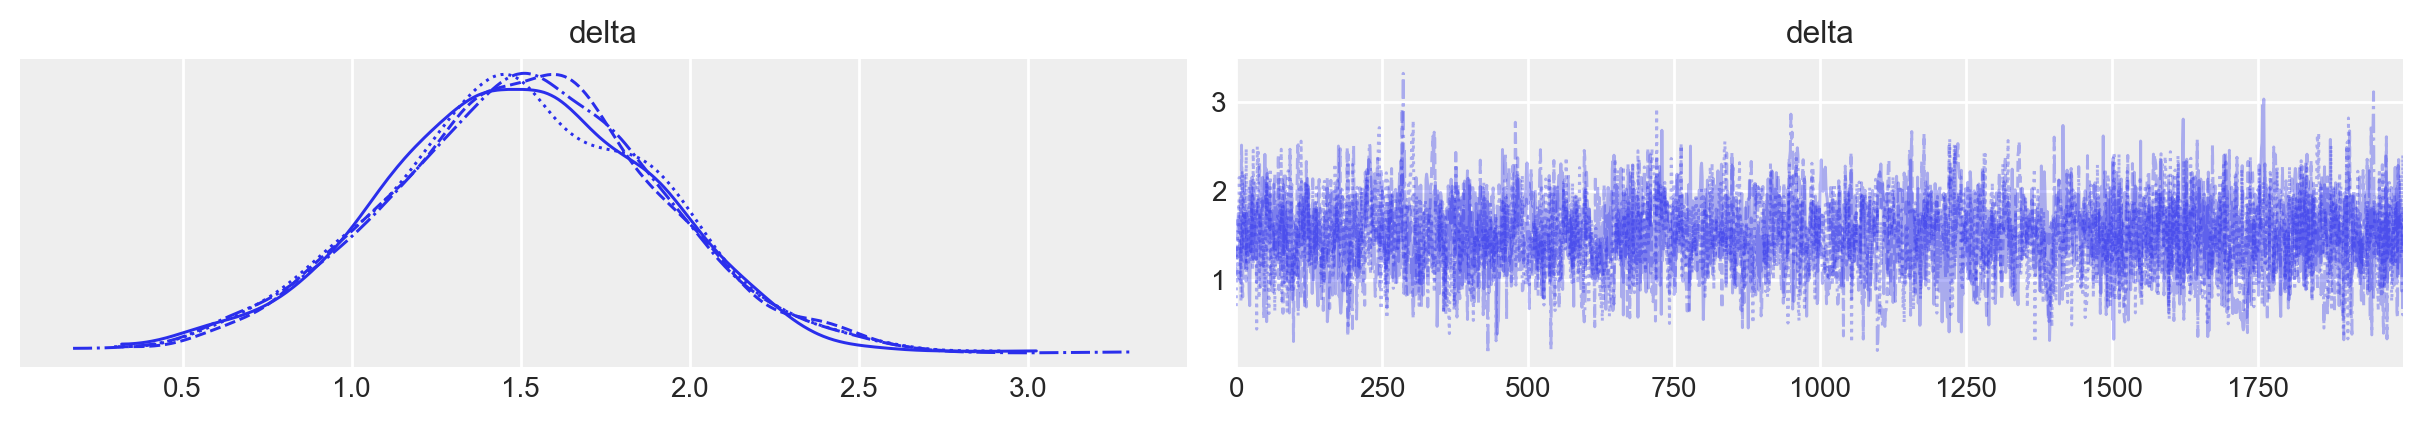

In [6]:
az.plot_trace(fit, var_names=["delta"])
plt.show()

Otteniamo un sommario numerico della distribuzione a posteriori del parametro di interesse.

In [7]:
az.summary(fit, var_names=["delta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,1.502,0.406,0.689,2.231,0.01,0.007,1666.0,1863.0,1.0


Si osserva che la stima di $\delta$ è coerente con il valore teorico utilizzato per la simulazione dei dati.

## Considerazioni Conclusive

L'approccio bayesiano discusso in questo capitolo è strettamente correlato ai modelli gerarchici con intercette casuali, ma esistono importanti differenze che possono influenzare la scelta tra i due metodi.

Entrambi gli approcci mirano a stimare la differenza tra i punteggi medi dei test nei due gruppi ($\delta = \mu_1 - \mu_2$). Sia la marginalizzazione dei parametri di disturbo sia l'adozione di un modello gerarchico conducono a una distribuzione a posteriori per $\delta$, tenendo conto delle variazioni individuali nei punteggi ($\theta_j$). Queste variazioni individuali, che non possono essere attribuite direttamente all'effetto di gruppo, vengono considerate in entrambi i metodi per garantire una stima accurata di $\delta$.

Tuttavia, ci sono differenze chiave tra i due approcci. La marginalizzazione si concentra sulla riduzione della complessità del modello, permettendo di isolare i parametri di interesse dopo aver considerato quelli di disturbo. Al contrario, il modello gerarchico prevede sin dall'inizio una struttura che include relazioni gerarchiche tra i parametri. In questo caso, la marginalizzazione avviene naturalmente durante il processo di inferenza, rendendo l'approccio gerarchico più integrato e coerente nella modellazione di dati complessi.

In termini di flessibilità e interpretazione, il modello gerarchico offre vantaggi significativi. La sua struttura consente di aggiungere facilmente ulteriori livelli di variazione o effetti casuali, rendendolo particolarmente adatto a contesti complessi con molteplici livelli gerarchici o dipendenze strutturate. D'altra parte, la marginalizzazione è un metodo diretto per concentrarsi sui parametri di interesse, ma potrebbe risultare meno flessibile quando si tratta di estendere il modello per includere nuove variabili o fonti di variazione.

Infine, i modelli gerarchici bayesiani sono noti per la loro robustezza in contesti con più fonti di variazione e sono spesso preferiti in situazioni complesse. La loro capacità di modellare relazioni gerarchiche e dipendenze nei dati li rende strumenti particolarmente potenti per l'inferenza. Sebbene la marginalizzazione sia un approccio efficace, può risultare limitata rispetto ai modelli gerarchici quando si affrontano problemi con strutture dati più complesse.

In conclusione, sebbene entrambi gli approcci producano stime simili per parametri come $\delta$, il modello gerarchico bayesiano offre un quadro più generale e flessibile per gestire la complessità dei dati, soprattutto in presenza di più livelli di variazione o dipendenze strutturate. Pertanto, i modelli gerarchici sono generalmente preferibili in contesti più complessi o quando è necessaria una maggiore flessibilità nella modellazione, in linea con le indicazioni della letteratura scientifica.

## Informazioni sull'Ambiente di Sviluppo

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Oct 13 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
pandas    : 2.2.2
arviz     : 0.18.0
cmdstanpy : 1.2.4
logging   : 0.5.1.2
numpy     : 1.26.4
seaborn   : 0.13.2
scipy     : 1.14.0

Watermark: 2.4.3

